# Team Project for ITC 6110 (NLP)

## Chistodoulidi Aspasia, Kontoudakis Nikos, Petrou Sofia

In [1]:
import sys
sys.path.append('/usr/lib/python3.13/site-packages') 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

2025-06-15 16:52:54.591557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### read the data

In [3]:
original_data = pd.read_csv(filepath_or_buffer="fake_or_real_news.csv", header=0, names= ["id", "title", "text", "label"])

In [4]:
original_data.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# Data cleaning and quality checks

## remove empty strings

In [5]:
only_whitespace = original_data.map(lambda x: isinstance(x, str) and x.strip() == '')
rows_any_whitespace = only_whitespace.any(axis=1)
# print removed rows
# print(original_data[rows_any_whitespace]["text"])

print(f"{len(original_data[rows_any_whitespace])} rows were removed")
original_data = original_data[~rows_any_whitespace]

36 rows were removed


In [6]:
original_data.isnull().sum()
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6299 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6299 non-null   int64 
 1   title   6299 non-null   object
 2   text    6299 non-null   object
 3   label   6299 non-null   object
dtypes: int64(1), object(3)
memory usage: 246.1+ KB


### preprocessing

# combine the title and text column into one

In [7]:
# title_text_df = original_data[["title", "text"]]
title_text_df = original_data["title"]+ " "+ original_data["text"]
target = original_data['label'].map({'FAKE': 0, 'REAL': 1})

# Data Processing

## Lowercase

In [8]:
def lowercase_text(text):
    # Convert text to lowercase.
    return str(text).lower()

In [9]:
# Apply lowercase function to all summaries
title_text_df = title_text_df.apply(lowercase_text)

## Replace URLs

In [10]:
# Define a regex pattern to identify URLs in the text
url_pattern = r"(?:https?|ftp)://[^\s/$.?#].[^\s]*"

def replace_urls(text):
    """
    Replace URLs in the text with the token 'URL'.
    Prints before and after if a replacement occurs.
    """
    text_str = str(text)
    replaced_text = re.sub(url_pattern, 'URL', text_str)
    return replaced_text

In [11]:
# Apply URL replacement to all summaries
title_text_df = title_text_df.apply(replace_urls)

## Replacing Emojis

In [12]:
# re.compile will compile the regex pattern into a regex object, necessary for 
# efficient pattern matching. This creates a reusable pattern object that can be
# used multiple times without recompiling the pattern each time, improving performance.
# u stands for Unicode
emoji_pattern = re.compile("["

    # Emoticons (e.g., 😀😁😂🤣😃😄😅😆)
    u"\U0001F600-\U0001F64F"  

    # Symbols & pictographs (e.g., 🔥🎉💡📦📱)
    u"\U0001F300-\U0001F5FF"  

    # Transport & map symbols (e.g., 🚗✈️🚀🚉)
    u"\U0001F680-\U0001F6FF"  

    # Flags (e.g., 🇺🇸🇬🇧🇨🇦 — these are pairs of regional indicators)
    u"\U0001F1E0-\U0001F1FF"  

    # Dingbats (e.g., ✂️✈️✉️⚽)
    u"\u2700-\u27BF"          

    # Supplemental Symbols & Pictographs (e.g., 🤖🥰🧠🦾)
    u"\U0001F900-\U0001F9FF"  

    # Symbols & Pictographs Extended-A (e.g., 🪄🪅🪨)
    u"\U0001FA70-\U0001FAFF"  

    # Miscellaneous symbols (e.g., ☀️☁️☂️⚡)
    u"\u2600-\u26FF"          

    "]+", flags=re.UNICODE)


In [13]:
# This pattern will match common text-based emoticons that aren't covered by the emoji Unicode ranges
# These emoticons are made up of regular ASCII characters like colons, parentheses, etc.

emoticon_pattern = re.compile(r'(:\)|:\(|:D|:P|;\)|:-\)|:-D|:-P|:\'\(|:\||:\*)')

In [14]:
def remove_and_print(text):
    if emoji_pattern.search(text) or emoticon_pattern.search(text):
        print(f"Before: {text}")
        text = emoji_pattern.sub('', text)
        text = emoticon_pattern.sub('', text)
        print(f"After: {text}")
        print()
    return text

## Replacing Usernames

In [15]:
def replace_usernames(text):
    """
    Replace email addresses and true @usernames with 'USER'.
    Avoid matching embedded @ in profanity or stylized words.
    Print before and after if replacement occurs.
    """
    original = str(text)
    updated = original

    # Replace full email addresses
    updated = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', 'USER', updated)

    # Replace @usernames only when preceded by space, punctuation, or start of string
    updated = re.sub(r'(?:(?<=^)|(?<=[\s.,;!?]))@\w+\b', 'USER', updated)

    return updated

# Apply username replacement to all summaries
title_text_df = title_text_df.apply(replace_usernames)

## Removing Non-Alphabets

In [16]:
def clean_text(text, keep_punct=False):
    """
    Clean and normalize text for NLP classification tasks.
    
    Parameters:
    - text (str): The input text to be cleaned.
    - keep_punct (bool): 
        If True, retains key punctuation (. ! ?) which may carry emotional or contextual weight.
        If False, removes all non-alphabetic characters for simpler lexical analysis.
    
    Returns:
    - str: The cleaned text string, lowercased and stripped of unwanted characters.
    
    This function is designed for flexibility across different NLP tasks like sentiment analysis,
    topic classification, or spam detection. It handles:
    - Lowercasing text for normalization
    - Removing or preserving select punctuation
    - Removing digits, symbols, and special characters
    - Reducing multiple spaces to a single space
    - Optionally printing changes for debugging or logging

    When to use `keep_punct=True`:
    - Sentiment analysis: punctuation (e.g., "!", "?") can reflect strong emotion
    - Social media or informal text: expressive punctuation often carries signal
    - Sarcasm, emphasis, or tone-sensitive tasks

    When to use `keep_punct=False`:
    - Topic classification or document clustering: punctuation rarely adds value
    - Preprocessing for bag-of-words, TF-IDF, or topic modeling
    - When punctuation is inconsistent or noisy (e.g., OCR scans, scraped data)
    """
    
    # Convert input to string (safe handling)
    original = str(text)

    if keep_punct:
        # Keep only lowercase letters, spaces, and select punctuation (. ! ?)
        # Useful for capturing tone/sentiment
        cleaned = re.sub(r"[^a-z\s.!?]", "", original)
    else:
        # Keep only lowercase letters and spaces; remove all punctuation and symbols
        cleaned = re.sub(r"[^a-z\s]", "", original)

    # Normalize whitespace (collapse multiple spaces to one, strip leading/trailing)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # Optional: print before and after if a change occurred
    return cleaned

In [17]:
# Apply non-alphabet removal to all summaries
title_text_df = title_text_df.apply(lambda x: clean_text(x, keep_punct=True))

## Removing Consecutive letters

In [18]:
def remove_consecutive_letters(text, max_repeat=2):
    """
    Normalize elongated words by limiting repeated characters.

    In informal or emotional text (e.g., reviews, tweets), users often repeat letters
    to add emphasis: "sooooo good", "loooove it", "greeaaat".
    
    This function reduces any character repeated more than `max_repeat` times 
    to exactly `max_repeat` occurrences (default: 2), preserving emphasis without bloating vocabulary.

    Parameters:
    - text (str): The input text
    - max_repeat (int): The maximum allowed repetitions for any character

    Returns:
    - str: Text with repeated characters normalized
    """
    text_str = str(text)
    pattern = r'(\w)\1{' + str(max_repeat) + r',}'
    cleaned = re.sub(pattern, r'\1' * max_repeat, text_str)

    return cleaned

In [19]:
# Apply consecutive letter removal to all summaries
title_text_df = title_text_df.apply(lambda x: remove_consecutive_letters(x, max_repeat=2))

## Removing Short Words

In [20]:
def remove_short_words(text, min_length=3, preserve_words=None):
    """
    Remove short words from text based on a minimum length threshold.
    
    Parameters:
    - text (str): The input text
    - min_length (int): Minimum word length to keep (default = 3)
    - preserve_words (set or list): Optional set of short but important words to keep (e.g., {'no', 'not'})
    
    Returns:
    - str: Text with short words removed, except for preserved ones
    
    Notes:
    - Use with care in sentiment analysis. Important short words like 'no', 'not', 'bad' may affect meaning.
    - Best used after stopword removal or on very noisy text.
    """
    preserve = set(preserve_words or [])
    words = str(text).split()
    filtered = [word for word in words if len(word) >= min_length or word.lower() in preserve]
    result = ' '.join(filtered)

    return result

In [21]:
# Apply short word removal to all summaries
title_text_df = title_text_df.apply(lambda x: remove_short_words(x, min_length=3, preserve_words={'no', 'not'}))

## Removing Stopwords

In [22]:
# Download stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Sample stopwords:", list(stopwords.words('english'))[:10])

Sample stopwords: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [23]:
# Define stopwords but keep critical ones like "not"
base_stopwords = set(stopwords.words('english'))
preserve = {'no', 'not', 'nor', 'never'}
custom_stopwords = base_stopwords - preserve

In [24]:
def remove_stopwords(text):
    """
    Remove stopwords from text, preserving key negation words.

    This function uses a customized stopword list that retains important
    short words like 'not', 'no', 'nor', and 'never' which carry significant
    meaning in tasks like sentiment analysis.

    Parameters:
    - text (str): Lowercased input text

    Returns:
    - str: Text with stopwords removed, but critical negation words preserved
    """
    words = str(text).split()
    filtered = [word for word in words if word not in custom_stopwords]
    result = ' '.join(filtered)
    
    return result

In [25]:
# Apply remove_stopwords
title_text_df = title_text_df.apply(remove_stopwords)

## Lemmatization

In [26]:
# Download required NLTK resources
nltk.download('wordnet')  # Download WordNet, a lexical database of English words
nltk.download('omw-1.4')  # WordNet Lemmas sometimes need this, which is a mapping of WordNet lemmas to their Part of Speech (POS) tags.
nltk.download('averaged_perceptron_tagger_eng')  # Download English POS tagger

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/nikos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/nikos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/nikos/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [27]:
# POS mapping function 
# POS tags can be: ADJ (adjective), ADV (adverb), NOUN (noun), VERB (verb), etc
def get_wordnet_pos(tag):
    # Determine the WordNet POS tag based on the first letter of the input tag
    if tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif tag.startswith('R'):
        return wordnet.ADV  # Adverb
    else:
        return wordnet.NOUN  # Default to Noun if no match


def lemmatize_text(text):
    """
    Lemmatize text using WordNet lemmatizer with POS tagging.

    This version prints each change along with the POS tag of the changed word.
    """
    # Convert the input text to a string to ensure compatibility
    original_text = str(text)
    # Split the text into individual words
    words = original_text.split()
    # Obtain Part of Speech (POS) tags for each word
    pos_tags = pos_tag(words)

    # Initialize lists to store lemmatized words and any changes
    lemmatized_words = []
    changes = []

    # Iterate over each word and its POS tag
    for word, tag in pos_tags:
        # Map the POS tag to a WordNet POS tag
        wn_tag = get_wordnet_pos(tag)
        # Lemmatize the word using the mapped POS tag
        lemma = lemmatizer.lemmatize(word, wn_tag)

        # Check if the lemmatized word is different from the original
        if lemma != word:
            # Record the change if a difference is found
            changes.append((word, lemma, tag))
        # Add the lemmatized word to the list
        lemmatized_words.append(lemma)

    # Join the lemmatized words back into a single string
    result = ' '.join(lemmatized_words)
    return result

In [28]:
# Apply lemmatization to all summaries
title_text_df = title_text_df.apply(lemmatize_text)
print(title_text_df)

0       smell hillary fear daniel greenfield shillman ...
1       watch exact moment paul ryan commit political ...
2       kerry paris gesture sympathy u.s. secretary st...
3       bernie supporter twitter erupt anger dnc try w...
4       battle new york primary matter primary day new...
                              ...                        
6330    state department say cant find emails clinton ...
6331    pb stand plutocratic pentagon pb stand plutocr...
6332    antitrump protester tool oligarchy information...
6333    ethiopia obama seek progress peace security ea...
6334    jeb bush suddenly attack trump. here matter je...
Length: 6299, dtype: object


In [29]:
title_text_df.to_csv("test.csv")

### Split train and test data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(title_text_df, target, test_size=0.2, random_state=55)

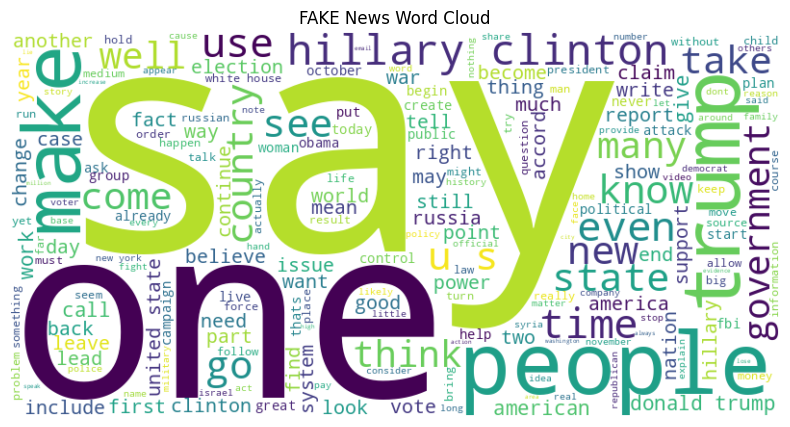

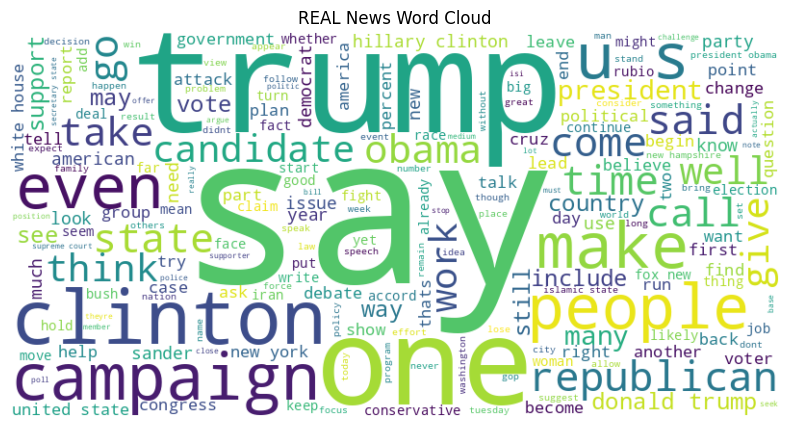

In [31]:
fake_texts = title_text_df[target == 0]
real_texts = title_text_df[target == 1]

# join all text for each class into one string
fake_text = ' '.join(fake_texts.astype(str))
real_text = ' '.join(real_texts.astype(str))

# fake news word cloud
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('FAKE News Word Cloud')
plt.show()

# real news word cloud
real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title('REAL News Word Cloud')
plt.show()

### Supervised Learning (4.2, DL)

In [32]:
# parameters
vocab_size = 10000
max_len = 100
embedding_dim = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))  # for binary classification

In [33]:
# build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/usr/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
# train the model
history= model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7025 - loss: 0.5698 - val_accuracy: 0.8661 - val_loss: 0.3175
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9425 - loss: 0.1754 - val_accuracy: 0.8750 - val_loss: 0.2986
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9751 - loss: 0.0714 - val_accuracy: 0.8264 - val_loss: 0.4472
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9845 - loss: 0.0559 - val_accuracy: 0.8720 - val_loss: 0.5717
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9908 - loss: 0.0269 - val_accuracy: 0.8581 - val_loss: 0.5349


In [35]:
# evaluate
loss, acc = model.evaluate(X_test_pad, y_test)
print(f'test accuracy: {acc:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8719 - loss: 0.4769 
test accuracy: 0.8651


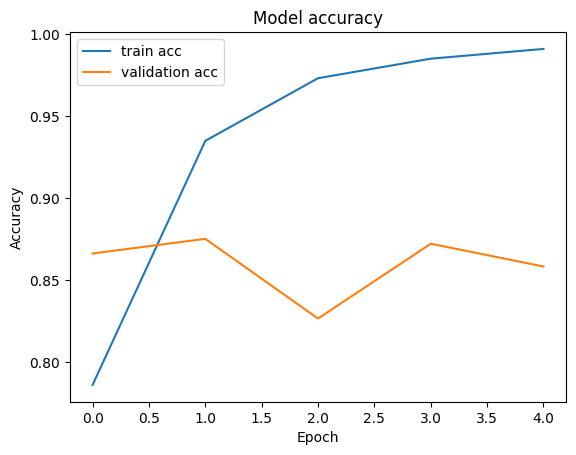

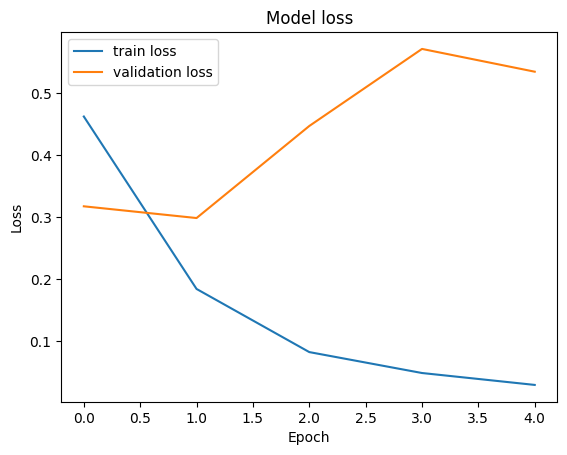

In [36]:
# plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


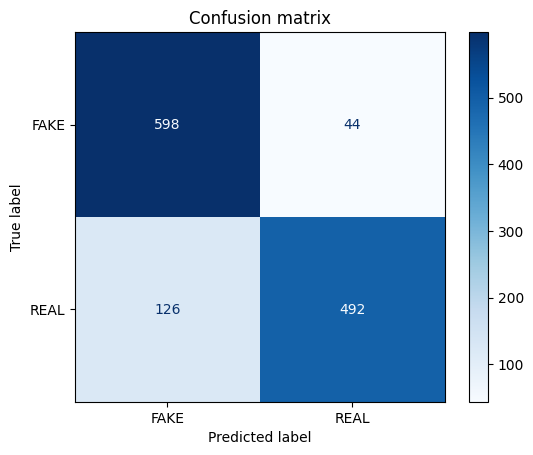

In [37]:
y_pred = model.predict(X_test_pad)
y_pred_bin = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
disp.plot(cmap='Blues')
plt.title('Confusion matrix')
plt.show()

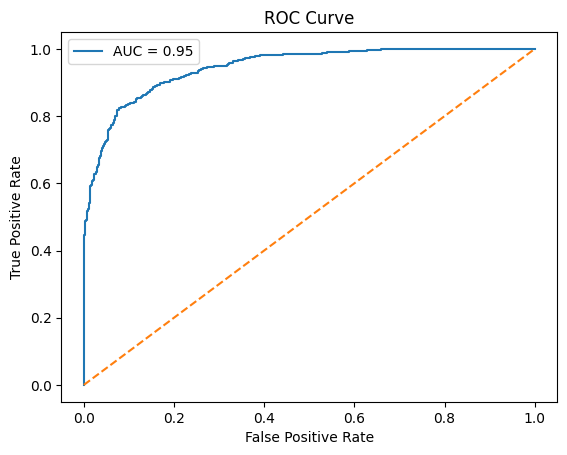

In [38]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()